In [7]:
# If using GPU as accelerator
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat May  9 14:42:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [8]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
%cd "/content/drive/My Drive/Colab Notebooks/deep-learning-group"

/content/drive/My Drive/Colab Notebooks/deep-learning-group


In [10]:
import autoreload
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
%reload_ext autoreload

In [0]:
import glob
import cv2
import numpy as np
import os


from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, AveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, LearningRateScheduler
import csv
import helpers
import pandas as pd
import split_utils
import math

In [13]:
DATA_DIR = '/content/drive/My Drive/Colab Notebooks/dataset'

batch_size_train = 200
val_size_train = 30
batch_size = 32

colorMode = 'rgb'
classMode = "categorical"
imgSize = 64

base_dir, train_dir, test_dir = split_utils.train_valid_split(DATA_DIR, 0.2, seed=1)

datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1, 
                             rescale=1./255,
                             zoom_range=0.3,
                             validation_split=0.25,
                             horizontal_flip=True)

train_generator = datagen.flow_from_directory(train_dir,
                                            target_size=(imgSize, imgSize),
                                            color_mode=colorMode,
                                            class_mode=classMode,
                                            batch_size=batch_size_train,
                                            subset='training')

validation_generator = datagen.flow_from_directory(train_dir,
                                            target_size=(imgSize, imgSize),
                                            color_mode=colorMode,
                                            class_mode=classMode,
                                            batch_size=batch_size_train,
                                            subset='validation')

Found 778 images belonging to 17 classes.
Found 254 images belonging to 17 classes.


**Callback functions list**

In [0]:
early_stop = EarlyStopping(monitor='val_accuracy',
                           min_delta=0.001,
                           patience=20)

**Simple CNN model**

In [0]:
def step_decay(epoch):
  initial_lrate = 0.008
  drop = 0.8
  epochs_drop = 5
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate

lrate = LearningRateScheduler(step_decay)

In [0]:
cvsores_1 = []
filepath_1 = "Weights_1.best.hdf5"
checkpoint_1 = ModelCheckpoint(filepath_1, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

logpath_1 = "Model_1_history.csv"
log_1 = CSVLogger(logpath_1, append=False)

callback_list_1 = [early_stop, checkpoint_1, log_1, lrate]

def get_compiled_model_1(optimizer='adam', loss='categorical_crossentropy'):
  keras.backend.clear_session()
  model = Sequential([
                      Conv2D(64, activation='relu', kernel_size=3, input_shape=(imgSize, imgSize, 3)),
                      Conv2D(64, activation='relu', kernel_size=3),
                      BatchNormalization(),
                      MaxPooling2D(),
                      Conv2D(128, activation='relu', kernel_size=3),
                      Conv2D(128, activation='relu', kernel_size=3),
                      BatchNormalization(),
                      MaxPooling2D(),
                      Flatten(),
                      Dense(256, activation='relu'),
                      Dropout(0.2),
                      Dense(128, activation='relu'),
                      Dropout(0.2),
                      Dense(64, activation='relu'),
                      Dropout(0.2),
                      Dense(32, activation='relu'),
                      Dropout(0.2),
                      Dense(17, activation='softmax')
  ])
  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
  return model

In [0]:
#@title Default title text
model_1 = get_compiled_model_1()

history = model_1.fit_generator(train_generator,
                      steps_per_epoch=50,
                      epochs=100,
                      validation_data=validation_generator,
                      validation_steps=20,
                      callbacks=callback_list_1)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 3.1852 - accuracy: 0.0690
Epoch 00001: val_accuracy improved from -inf to 0.07126, saving model to Weights_1.best.hdf5
50/50 [==============================] - 80s 2s/step - loss: 3.1852 - accuracy: 0.0690 - val_loss: 2.8298 - val_accuracy: 0.0713 - lr: 0.0080
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 2.8298 - accuracy: 0.0700
Epoch 00002: val_accuracy did not improve from 0.07126
50/50 [==============================] - 80s 2s/step - loss: 2.8298 - accuracy: 0.0700 - val_loss: 2.8288 - val_accuracy: 0.0709 - lr: 0.0080
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 2.8302 - accuracy: 0.0666
Epoch 00003: val_accuracy did not improve from 0.07126
50/50 [==============================] - 80s 2s/step - loss: 2.8302 - accuracy: 0.0666 - val_loss: 2.8288 - val_accuracy: 0.0681 - lr: 0.0080
Epoch 4/100
 9/50 [====>.........................] - ETA: 47s - loss: 2.8271 - accurac

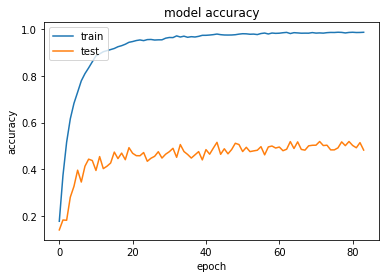

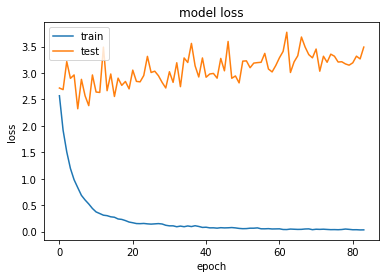

In [18]:
log_data = pd.read_csv(logpath_1)
helpers.plotTrainingHistory(log_data)

In [20]:
model_1 = load_model(filepath_1)
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       3

In [21]:
testgen = ImageDataGenerator(rescale=1./255)

test_generator = testgen.flow_from_directory(test_dir,
                                            target_size=(imgSize, imgSize),
                                            color_mode=colorMode,
                                            class_mode=classMode,
                                            batch_size=batch_size,
                                            shuffle=False)

y_pred = model_1.predict_generator(test_generator, steps = test_generator.samples//batch_size+1, verbose=1)

Found 266 images belonging to 17 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
2/9 [=====>........................] - ETA: 38s

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


9/9 [==============================] - 106s 12s/step


In [0]:
le = LabelEncoder()
listLabel = list(test_generator.class_indices.keys())
le.fit(listLabel)
encodedLabel = le.transform(listLabel)

In [0]:
y_pred = np.argmax(y_pred, axis=1)

In [24]:
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88        14
           1       0.78      1.00      0.88        18
           2       0.88      0.93      0.90        15
           3       0.60      0.43      0.50        14
           4       0.86      0.75      0.80        16
           5       0.86      0.80      0.83        15
           6       0.67      0.93      0.78        15
           7       0.72      0.72      0.72        18
           8       0.83      0.71      0.77        14
           9       0.93      0.72      0.81        18
          10       1.00      0.94      0.97        16
          11       0.92      0.80      0.86        15
          12       0.78      0.93      0.85        15
          13       0.77      0.67      0.71        15
          14       0.94      0.83      0.88        18
          15       0.80      0.80      0.80        15
          16       0.75      0.80      0.77        15

    accuracy              

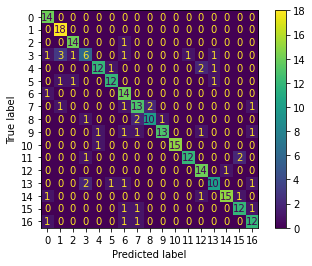

In [25]:
ConfusionMatrixDisplay(confusion_matrix(test_generator.classes, y_pred), encodedLabel).plot()

**Simple model using transfer learning**

In [0]:
cvscores_2 = []
def get_compiled_model_2():
  keras.backend.clear_seesion()
  baseModel = VGG16(weights='imagenet',
                    include_top=False,
                    input_tensor=Input(shape=(imgSize, imgSize, 3)))
  
  for layer in baseModel.layers[:-5]:
    layer.trainable = False
  
  

In [0]:
test_generator.class_indices

**Results Summary**